# Reducción de varianza en simulación Monte-Carlo
                     Dr. Julio César Galindo

### Muestreo por Importancia

Supongamos que queremos estimar la probabilidad $\mathbb{P}(X>5)$. Si usamos integración Monte Carlo utilizando muestras de $N(0,1)$ es inútil ya que casi todas las muestras serán rechazadas. Sin embargo, podemos utilizar la densidad exponencial truncada en $5$ como estimador de importancia y utilizar el muestreo de importancia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as stats
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

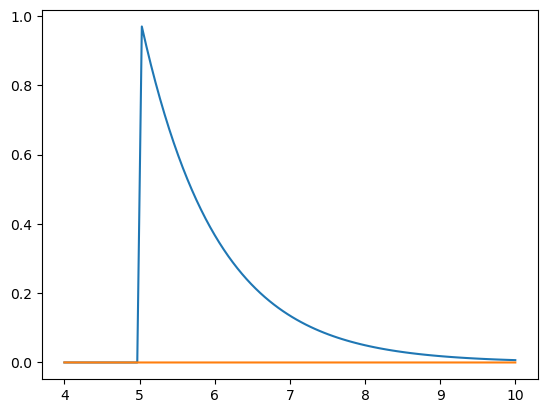

In [2]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))
plt.plot(x, stats.norm().pdf(x));

Esperamos alrededor de 3 extracciones de 10.000.000 de muestras $N(0,1)$ tener un valor mayor que 5. Por lo tanto, simplemente muestrear desde normales $N(0,1)$ es ineficaz para la integración de Monte Carlo.

In [3]:
h_true =1 - stats.norm().cdf(5)
h_true

2.866515719235352e-07

In [4]:
# Integración Monte-Carlo
n = 10000
y = stats.norm().rvs(n)
h_mc = 1.0/n * np.sum(y > 5)
# error relativo
h_mc, np.abs(h_mc - h_true)/h_true

(0.0, 1.0)

In [5]:
# Usando muestreo por importancia
n = 10000
y = stats.expon(loc=5).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y))
# error relativo
h_is, np.abs(h_is- h_true)/h_true

(2.820092836305562e-07, 0.016194881687993334)

In [6]:
def s_x(x):
    return 1/(1 + np.exp(-x))

In [7]:
def distribucion(mu=0, sigma=1):
    distribucion = stats.norm(mu, sigma)
    return distribucion

In [8]:
# variables
n = 1000
mu_true = 3.5
sigma_true = 1
mu_aprox = 3
sigma_aprox = 1
f_x = distribucion(mu_true, sigma_true)
g_x = distribucion(mu_aprox, sigma_aprox)

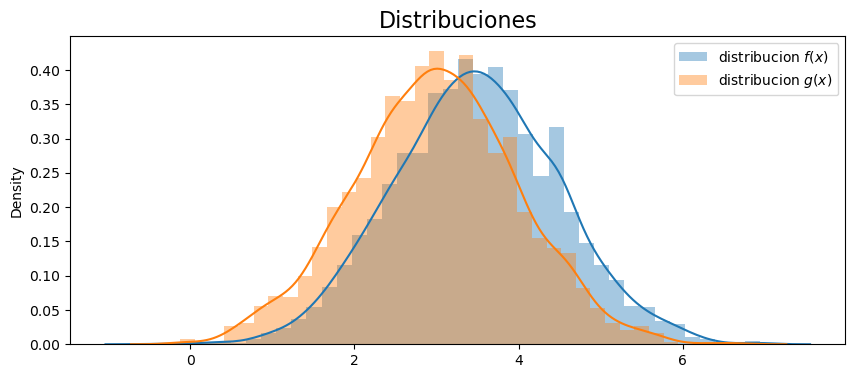

In [9]:
plt.figure(figsize=[10, 4])
sns.distplot([np.random.normal(mu_true, sigma_true) for _ in range(3000)], label="distribucion $f(x)$")
sns.distplot([np.random.normal(mu_aprox, sigma_aprox) for _ in range(3000)], label="distribucion $g(x)$")
plt.title("Distribuciones", size=16)
plt.legend()

In [10]:
s = 0
for i in range(n):
        # draw a sample
        x_i = np.random.normal(mu_true, sigma_true)
        s += s_x(x_i)

print("valor simulado", s / n)



valor simulado 0.9567540254258757


In [11]:
# calculamos el valor del muestreo a partir de una distribución diferente
valores = []
for i in range(n):
        x_i = np.random.normal(mu_aprox, sigma_aprox)
        valor = s_x(x_i) * (f_x.pdf(x_i) / g_x.pdf(x_i))
        valores.append(valor)

print("media {} varianza {}".format(np.mean(valores), np.var(valores)))

media 0.9639540880818019 varianza 0.2926295628259492


In [12]:
# valores para g(x) diferente
n = 5000
mu_true = 3.5
sigma_true = 1
mu_aprox = 1
sigma_aprox = 1
f_x = distribucion(mu_true, sigma_true)
g_x = distribucion(mu_aprox, sigma_aprox)

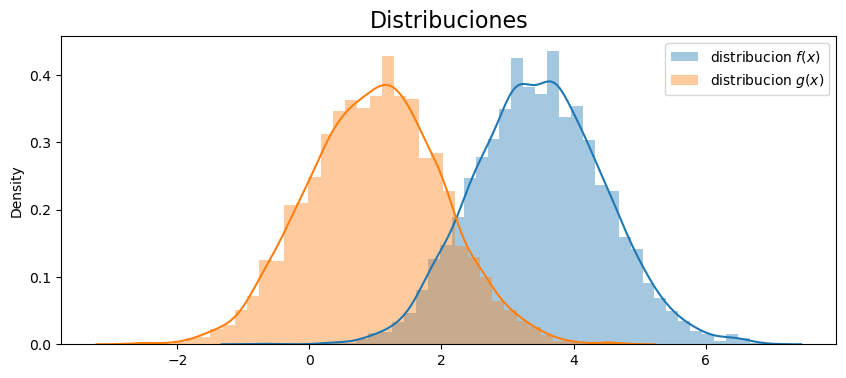

In [13]:
# Gráficas
plt.figure(figsize=[10, 4])
sns.distplot([np.random.normal(mu_true, sigma_true) for _ in range(3000)], label="distribucion $f(x)$")
sns.distplot([np.random.normal(mu_aprox, sigma_aprox) for _ in range(3000)], label="distribucion $g(x)$")
plt.title("Distribuciones", size=16)
plt.legend()

In [14]:
valores_1 = []
    # necesitamos más muestras
for i in range(n):
        # muestras de diferentes distribuciones
        x_i = np.random.normal(mu_aprox, sigma_aprox)
        valor = s_x(x_i) * (f_x.pdf(x_i) / g_x.pdf(x_i))
        valores_1.append(valor)

print("media {} varianza {}".format(np.mean(valores_1), np.var(valores_1)))

media 0.9965849495455779 varianza 59.60533304675889


### Variables antitéticas

In [15]:
# Definimos la siguiente función
def r(x):
    return x * np.cos(71*x) + np.sin(13*x)

In [16]:
# Integramos

from sympy import sin, cos, symbols, integrate

x = symbols('x')
sol = integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(16)
sol

0.02025493910239406

In [17]:
# Monte-Carlo
n = 10000
u = np.random.random(n)
x = r(u)
y = 1.0/n * np.sum(x)
y, abs(y-sol)/sol

(0.023067658868997906, 0.1388658713010594)

In [18]:
# Variables antitéticas
u = np.r_[u[:n//2], 1-u[:n//2]]
x = r(u)
y = 1.0/n * np.sum(x)
y, abs(y-sol)/sol

(0.015231095220998586, 0.2480305596575046)

## Aplicaciones

El precio de una opción *call* europea bajo riesgo neutral está dada por la ecuación:
$$\mathbb{E}_{\mathbb{Q}}\left[e^{-rT}(S_{0}e^{Z_T}-K)^{+} \right]$$
con $Z_{T}\sim N\left(\left(r-\frac{\sigma^2}{2} \right)T, \sigma^2 T \right)$

(ver https://bookdown.org/maxime_debellefroid/MyBook/a-deeper-understanding-of-options.html)

La solución a tal ecuación está dada por la fórmula de Black-Scholes:

In [19]:
def blackScholes(r, S, K, T, sigma, opt_type="c"):
    "Calcula precio por BS  de paridad call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if opt_type == "c":
            price = S*sc.stats.norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*sc.stats.norm.cdf(d2, 0, 1)
        elif opt_type == "p":
            price = K*np.exp(-r*T)*sc.stats.norm.cdf(-d2, 0, 1) - S*sc.stats.norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Confirma la opción call o put, 'c' para Call o 'p' para Put!")


In [20]:
# parámetros

S0 = 100.0     # precio inicial
K = 170.0      # precio strike
T = 1.0        # tiempo (en años) de maduración
r = 0.06       # tasa libre de riesgo
vol = 0.20     # volatilidad (%)
dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
BS = blackScholes(r, S0, K, T, vol)
print("Precio Black-Scholes: ", round(BS,4))

Precio Black-Scholes:  0.0789


Si cambiamos la media $\mathbb{Q}$ a $\mathbb{Q}_0$, entonces
$$\mathbb{E}_{\mathbb{Q}_0}\left[e^{-rT}(S_{0}e^{Z_T}-K)^{+} \right]$$
con $Z_{T}\sim N\left(\left(\ln\left(\frac{K}{S_0}\right)-\frac{\sigma^2}{2} \right)T, \sigma^2 T \right)$


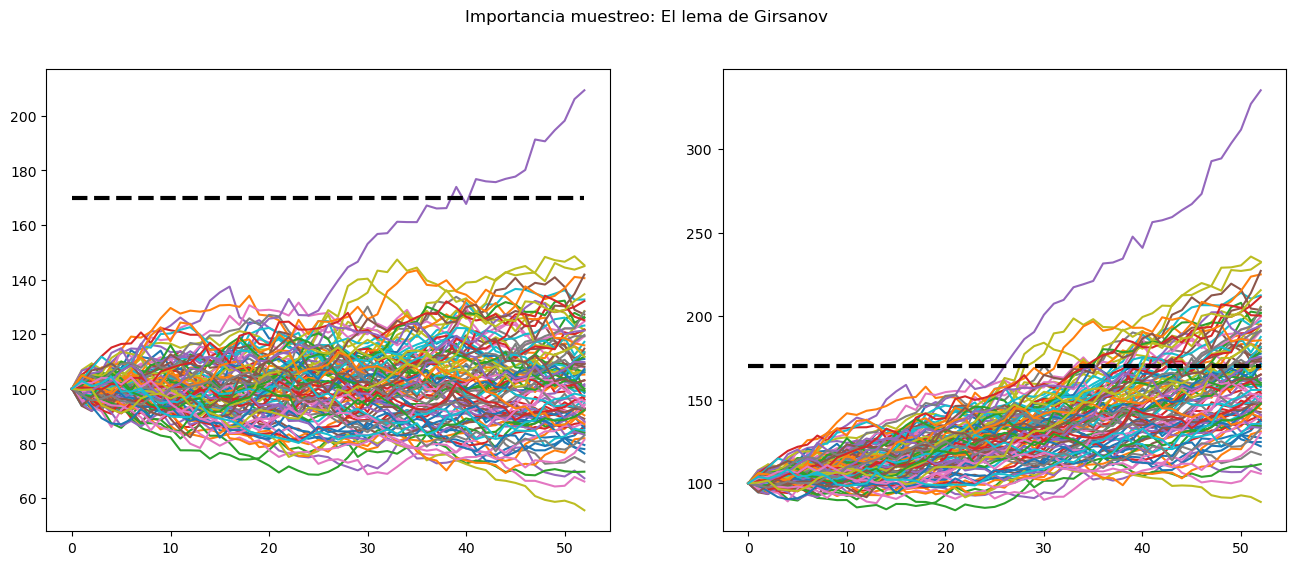

In [21]:
M = 100
N = 52

dt = T/N
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S0)

# Método Monte-Carlo 
Z = np.random.normal(0,1,size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
delta_lnSt2 = nudt2 + volsdt*Z 
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
lnSt2 = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt2 ) )
ST = np.exp(lnSt)
ST2 = np.exp(lnSt2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Importancia muestreo: El lema de Girsanov')
ax1.plot(ST)
ax1.plot([0,N],[K,K],'k--',linewidth=3)
ax2.plot(ST2)
ax2.plot([0,N],[K,K],'k--',linewidth=3)
plt.show()

Desafortunadamente, no existe una forma general para encontrar $g$ óptimo bajo la medida $d\mathbb{Q}_0$. Sin embargo, podemos encontrar un $g$ relativamente óptimo que reduce la varianza.

**Referencia:** Variance Reduction Techniques of Importance Sampling Monte Carlo Methods for Pricing Options
Journal of Mathematical Finance, 2013, 3, 431-436

In [22]:
# parámetros

S0 = 100.0     # precio inicial
K = 170.0      # precio strike
T = 1.0        # tiempo (en años) de maduración
r = 0.06       # tasa libre de riesgo
vol = 0.20     # volatilidad (%)
dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

p = sc.stats.norm(nudt,volsdt)
q = lambda mu: sc.stats.norm(mu, volsdt)
z_T = lambda x, mu, sig: mu + sig*x
f_0 = lambda z: np.exp(-r*T)*np.maximum(0, S0*np.exp(z)-K)

# Simulaciones
M = 1000000
def arg_min(x):
    x_T = np.random.normal(0, 1, M)
    z = z_T(x_T,nudt,volsdt)
    return np.mean( f_0(z)**2 * p.pdf(z)/q(x).pdf(z) )

# Optimización
mu_star = sc.optimize.fmin(lambda x: arg_min(x), nudt2, disp=True)
mu_star


C0_is, SE_is = [], []
for M in np.arange(100,1000+100,100):
    mu = mu_star[0]
    x = np.random.randn(M)
    z = z_T(x,mu,volsdt)
    CT = f_0(z) * p.pdf(z)/q(mu).pdf(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    
    C0_is.append(C0)
    SE_is.append(SE)
    
C0_is = np.array(C0_is)
SE_is = np.array(SE_is)

print("El valor del Call ${0} con SE +/- {1}".format(np.round(C0_is,3),np.round(SE_is,3)))


C0_wo, SE_wo = [], []
for M in np.arange(100,1000+100,100):
    x = np.random.randn(M)
    z = z_T(x, nudt, volsdt)
    CT = f_0(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    C0_wo.append(C0)
    SE_wo.append(SE)
    
C0_wo = np.array(C0_wo)
SE_wo = np.array(SE_wo)

print("El valor del Call ${0} con SE +/- {1}".format(np.round(C0_wo,3),np.round(SE_wo,3)))

SE_Ratio = SE_wo/SE_is

print("Factor de reducción de la varianza {0}".format(np.round(SE_Ratio,3)))

import pandas as pd

M = np.arange(100,1000+100,100)
precios = pd.DataFrame(np.array([M, C0_wo.round(3), C0_is.round(3), SE_wo.round(3), SE_is.round(3), SE_Ratio.round(1)]).T, 
                      columns=['Simulaciones','Precio_wo', 'Precio_is','SE_wo', 'SE_is', 'Reduccion'])

print("Precio BS: ", BS)
precios

Optimization terminated successfully.
         Current function value: 0.012841
         Iterations: 15
         Function evaluations: 33
El valor del Call $[0.093 0.089 0.084 0.073 0.078 0.076 0.078 0.082 0.081 0.077] con SE +/- [0.008 0.006 0.005 0.004 0.004 0.003 0.003 0.003 0.003 0.003]
El valor del Call $[0.    0.046 0.097 0.12  0.172 0.068 0.175 0.112 0.047 0.137] con SE +/- [0.    0.046 0.087 0.087 0.091 0.044 0.073 0.057 0.028 0.044]
Factor de reducción de la varianza [ 0.     8.07  17.162 21.551 24.369 12.881 22.818 19.107  9.918 16.23 ]
Precio BS:  0.07888660119733348


,Simulaciones,Precio_wo,Precio_is,SE_wo,SE_is,Reduccion
0,100.0,0.000,0.093,0.000,0.008,0.0
1,200.0,0.046,0.089,0.046,0.006,8.1
2,300.0,0.097,0.084,0.087,0.005,17.2
3,400.0,0.120,0.073,0.087,0.004,21.6
4,500.0,0.172,0.078,0.091,0.004,24.4
5,600.0,0.068,0.076,0.044,0.003,12.9
6,700.0,0.175,0.078,0.073,0.003,22.8
7,800.0,0.112,0.082,0.057,0.003,19.1
8,900.0,0.047,0.081,0.028,0.003,9.9
9,1000.0,0.137,0.077,0.044,0.003,16.2
